In [1]:
import os
import pathlib
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


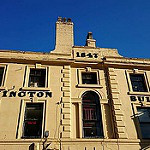

In [2]:
src_img = Image.open('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings/7570.jpg')
display(src_img)

In [3]:
np.array(src_img).shape

(150, 150, 3)

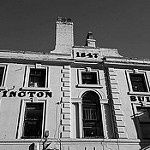

In [4]:
gray_img = ImageOps.grayscale(src_img)
display(gray_img)

In [5]:
np.array(gray_img).shape

(150, 150)

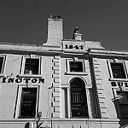

In [6]:
gray_resized_img = gray_img.resize(size=(128, 128))
display(gray_resized_img)

In [7]:
np.array(gray_resized_img).shape

(128, 128)

In [8]:
np.ravel(gray_resized_img)

array([ 51,  51,  51, ..., 181, 192, 186], dtype=uint8)

In [9]:
img_final = np.ravel(gray_resized_img) / 255.0

In [10]:
img_final

array([0.2       , 0.2       , 0.2       , ..., 0.70980392, 0.75294118,
       0.72941176])

In [11]:
def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    img = ImageOps.grayscale(img)
    img = img.resize(size=(128, 128))
    img = np.ravel(img) / 255.0
    return img

In [12]:
tst_img = process_image(img_path='/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings/7570.jpg')

In [13]:
tst_img

array([0.2       , 0.2       , 0.2       , ..., 0.70980392, 0.75294118,
       0.72941176])

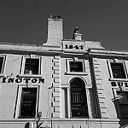

In [14]:
Image.fromarray(np.uint8(tst_img * 255).reshape((128, 128)))

In [15]:
def process_folder(folder: pathlib.PosixPath) -> pd.DataFrame:
    # We'll store the images here
    processed = []
    
    # For every image in the directory
    for img in folder.iterdir():
        # Ensure JPG
        if img.suffix == '.jpg':
            # Two images failed for whatever reason, so let's just ignore them
            try:
                processed.append(process_image(img_path=str(img)))
            except Exception as _:
                continue
           
    # Convert to pd.DataFrame
    processed = pd.DataFrame(processed)
    processed['class'] = folder.parts[-1]
    
    return processed

In [16]:
%%time

train_build = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/buildings'))
train_forest = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_train/seg_train/forest'))

train_set = pd.concat([train_build, train_forest], axis=0)

with open('train_set.pkl', 'wb') as f:
    pickle.dump(train_set, f)

CPU times: user 41.8 s, sys: 5.29 s, total: 47.1 s
Wall time: 2min 16s


In [17]:
train_set.shape

(3760, 16385)

In [18]:
%%time

test_build = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_test/seg_test/buildings'))
test_forest = process_folder(folder=pathlib.Path.cwd().joinpath('/content/drive/MyDrive/Selected Project/Intel Image Dataset/seg_test/seg_test/forest'))

test_set = pd.concat([test_build, test_forest], axis=0)

with open('test_set.pkl', 'wb') as f:
    pickle.dump(test_set, f)

CPU times: user 6.2 s, sys: 385 ms, total: 6.58 s
Wall time: 16.4 s


In [19]:
test_set.shape

(538, 16385)

In [20]:
train_set = shuffle(train_set).reset_index(drop=True)
test_set = shuffle(train_set).reset_index(drop=True)

In [21]:
train_set.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,class
0,0.482353,0.611765,0.478431,0.443137,0.619608,0.541176,0.305882,0.545098,0.635294,0.611765,0.529412,0.615686,0.737255,0.556863,0.529412,0.447059,0.682353,0.596078,0.560784,0.831373,0.600000,0.321569,0.564706,0.611765,0.431373,0.580392,0.662745,0.537255,0.572549,0.733333,0.627451,0.537255,0.650980,0.713725,0.450980,0.388235,0.427451,0.325490,0.403922,0.415686,...,0.125490,0.090196,0.266667,0.101961,0.054902,0.133333,0.156863,0.152941,0.200000,0.262745,0.117647,0.180392,0.286275,0.207843,0.145098,0.282353,0.388235,0.250980,0.176471,0.298039,0.235294,0.160784,0.247059,0.298039,0.254902,0.309804,0.384314,0.388235,0.329412,0.250980,0.364706,0.266667,0.219608,0.156863,0.352941,0.345098,0.164706,0.364706,0.227451,forest
1,0.325490,0.164706,0.588235,0.462745,0.443137,0.470588,0.470588,0.454902,0.619608,0.537255,0.129412,0.105882,0.062745,0.125490,0.372549,0.501961,0.223529,0.023529,0.054902,0.380392,0.482353,0.352941,0.815686,0.490196,0.447059,0.556863,0.431373,0.717647,0.615686,0.403922,0.435294,0.380392,0.282353,0.345098,0.384314,0.482353,0.490196,0.274510,0.392157,0.364706,...,0.164706,0.207843,0.117647,0.066667,0.156863,0.113725,0.137255,0.117647,0.125490,0.164706,0.117647,0.121569,0.141176,0.152941,0.098039,0.066667,0.133333,0.192157,0.117647,0.062745,0.196078,0.145098,0.215686,0.203922,0.066667,0.019608,0.145098,0.184314,0.152941,0.164706,0.109804,0.074510,0.215686,0.105882,0.027451,0.015686,0.050980,0.098039,0.054902,forest
2,0.062745,0.074510,0.078431,0.290196,0.219608,0.239216,0.466667,0.439216,0.164706,0.133333,0.145098,0.152941,0.349020,0.482353,0.145098,0.094118,0.133333,0.098039,0.180392,0.364706,0.454902,0.454902,0.568627,0.380392,0.364706,0.360784,0.262745,0.184314,0.188235,0.254902,0.180392,0.329412,0.313725,0.356863,0.443137,0.341176,0.458824,0.427451,0.372549,0.537255,...,0.384314,0.180392,0.074510,0.149020,0.356863,0.247059,0.160784,0.066667,0.047059,0.027451,0.047059,0.109804,0.196078,0.254902,0.133333,0.125490,0.086275,0.043137,0.015686,0.062745,0.074510,0.082353,0.129412,0.027451,0.152941,0.250980,0.090196,0.105882,0.082353,0.050980,0.133333,0.129412,0.015686,0.141176,0.078431,0.090196,0.074510,0.023529,0.054902,forest
3,0.615686,0.615686,0.619608,0.623529,0.627451,0.627451,0.631373,0.623529,0.623529,0.627451,0.627451,0.631373,0.631373,0.631373,0.631373,0.635294,0.635294,0.635294,0.639216,0.647059,0.643137,0.639216,0.639216,0.639216,0.635294,0.635294,0.635294,0.639216,0.647059,0.643137,0.643137,0.643137,0.647059,0.647059,0.647059,0.650980,0.654902,0.658824,0.654902,0.650980,...,0.321569,0.462745,0.352941,0.333333,0.364706,0.066667,0.058824,0.062745,0.066667,0.039216,0.035294,0.078431,0.211765,0.211765,0.243137,0.419608,0.121569,0.011765,0.019608,0.105882,0.250980,0.250980,0.352941,0.396078,0.396078,0.427451,0.376471,0.384314,0.600000,0.615686,0.749020,0.509804,0.301961,0.705882,0.345098,0.345098,0.349020,0.360784,0.243137,buildings
4,0.058824,0.054902,0.062745,0.039216,0.086275,0.082353,0.086275,0.137255,0.074510,0.066667,0.141176,0.356863,0.121569,0.039216,0.066667,0.070588,0.070588,0.070588,0.066667,0.070588,0.007843,0.427451,0.576471,0.101961,0.541176,0.325490,0.047059,0.094118,0.113725,0.074510,0.070588,0.117647,0.054902,0.066667,0.145098,0.156863,0.149020,0.509804,0.462745,0.392157,...,0.231373,0.580392,0.694118,0.486275,0.505882,0.788235,0.866667,0.941176,0.945098,0.772549,0.725490,0.831373,0.619608,0.325490,0.141176,0.400000,0.270588,0.113725,0.113725,0.125490,0.129412,0.200000,0.152941,0.160784,0.149020,0.070588,0.070588,0.074510,0.062745,0.062745,0.062745,0.054902,0.066667,0.078431,0.066667,0.070588,0.058824,0.050980,0.050980,forest
5,0.568627,0.807843,0.

In [22]:
test_set.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16345,16346,16347,16348,16349,16350,16351,16352,16353,16354,16355,16356,16357,16358,16359,16360,16361,16362,16363,16364,16365,16366,16367,16368,16369,16370,16371,16372,16373,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383,class
0,0.231373,0.345098,0.600000,0.454902,0.470588,0.545098,0.376471,0.866667,0.956863,0.552941,0.384314,0.427451,0.501961,0.360784,0.231373,0.176471,0.333333,0.458824,0.388235,0.384314,0.274510,0.227451,0.407843,0.431373,0.721569,0.349020,0.282353,0.301961,0.200000,0.337255,0.270588,0.317647,0.427451,0.400000,0.278431,0.235294,0.180392,0.207843,0.211765,0.180392,...,0.149020,0.113725,0.352941,0.454902,0.196078,0.266667,0.239216,0.168627,0.258824,0.309804,0.180392,0.141176,0.172549,0.243137,0.129412,0.094118,0.223529,0.149020,0.231373,0.250980,0.160784,0.192157,0.121569,0.168627,0.196078,0.098039,0.231373,0.262745,0.203922,0.239216,0.215686,0.325490,0.145098,0.203922,0.215686,0.172549,0.098039,0.086275,0.133333,forest
1,0.686275,0.360784,0.521569,0.541176,0.501961,0.376471,0.505882,0.486275,0.364706,0.615686,0.564706,0.494118,0.541176,0.694118,0.827451,0.247059,0.298039,0.325490,0.254902,0.541176,0.435294,0.254902,0.321569,0.415686,0.341176,0.278431,0.309804,0.345098,0.325490,0.478431,0.654902,0.478431,0.458824,0.345098,0.462745,0.274510,0.568627,0.615686,0.321569,0.278431,...,0.317647,0.180392,0.301961,0.192157,0.227451,0.219608,0.274510,0.423529,0.176471,0.282353,0.325490,0.309804,0.207843,0.243137,0.164706,0.168627,0.254902,0.200000,0.219608,0.109804,0.133333,0.431373,0.988235,0.792157,0.737255,0.874510,0.901961,0.952941,0.890196,0.858824,0.784314,0.568627,0.513725,0.498039,0.525490,0.447059,0.674510,0.862745,0.866667,forest
2,0.164706,0.200000,0.262745,0.317647,0.333333,0.145098,0.223529,0.356863,0.490196,0.309804,0.360784,0.592157,0.525490,0.329412,0.427451,0.592157,0.588235,0.305882,0.407843,0.584314,0.454902,0.074510,0.431373,0.560784,0.541176,0.549020,0.537255,0.529412,0.533333,0.529412,0.529412,0.533333,0.529412,0.529412,0.517647,0.529412,0.533333,0.521569,0.525490,0.529412,...,0.203922,0.094118,0.082353,0.035294,0.011765,0.000000,0.007843,0.674510,0.298039,0.003922,0.066667,0.113725,0.121569,0.321569,0.592157,0.074510,0.098039,0.235294,0.290196,0.137255,0.149020,0.141176,0.121569,0.113725,0.098039,0.082353,0.113725,0.137255,0.145098,0.129412,0.117647,0.137255,0.149020,0.094118,0.098039,0.129412,0.431373,0.596078,0.407843,buildings
3,0.556863,0.556863,0.556863,0.556863,0.560784,0.560784,0.560784,0.564706,0.568627,0.564706,0.552941,0.552941,0.556863,0.560784,0.560784,0.564706,0.564706,0.564706,0.564706,0.560784,0.564706,0.564706,0.564706,0.564706,0.564706,0.568627,0.568627,0.576471,0.580392,0.576471,0.564706,0.568627,0.576471,0.572549,0.560784,0.568627,0.580392,0.580392,0.572549,0.568627,...,0.600000,0.572549,0.572549,0.584314,0.568627,0.576471,0.556863,0.564706,0.568627,0.549020,0.552941,0.549020,0.560784,0.549020,0.521569,0.560784,0.529412,0.525490,0.525490,0.513725,0.533333,0.498039,0.533333,0.525490,0.501961,0.458824,0.458824,0.478431,0.474510,0.450980,0.443137,0.415686,0.372549,0.364706,0.356863,0.313725,0.313725,0.309804,0.282353,buildings
4,0.266667,0.341176,0.474510,0.447059,0.329412,0.203922,0.172549,0.160784,0.207843,0.262745,0.200000,0.258824,0.541176,0.501961,0.133333,0.203922,0.160784,0.176471,0.231373,0.258824,0.243137,0.235294,0.262745,0.270588,0.258824,0.368627,0.462745,0.764706,0.309804,0.227451,0.337255,0.368627,0.372549,0.145098,0.400000,0.525490,0.552941,0.686275,0.733333,0.278431,...,0.478431,0.364706,0.435294,0.478431,0.545098,0.549020,0.588235,0.498039,0.588235,0.498039,0.549020,0.611765,0.607843,0.643137,0.631373,0.647059,0.576471,0.639216,0.639216,0.572549,0.494118,0.580392,0.564706,0.545098,0.615686,0.537255,0.450980,0.462745,0.572549,0.552941,0.537255,0.643137,0.572549,0.411765,0.400000,0.458824,0.607843,0.670588,0.513725,forest
5,0.619608,0.650980

In [23]:
x_train = train_set.drop('class', axis=1)
x_train = np.array(x_train)
y_train = train_set['class']

x_test = test_set.drop('class', axis=1)
x_test = np.array(x_test)
y_test = test_set['class']

In [24]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [25]:
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(x_train, y_train)

SVC(kernel='linear', random_state=0)

In [26]:
y_pred = classifier.predict(x_test)
y_pred = (y_pred > 0.5)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[1 1]
 [1 1]
 [0 0]
 ...
 [0 0]
 [0 0]
 [1 1]]


In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(classifier,
                                                        x_test, y_test, cv=10, scoring='accuracy',
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(6,6))
plt.plot(train_sizes, train_mean, '--', color='blue',  label="Training score")
plt.plot(train_sizes, test_mean, color='blue', label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve
fpr,tpr ,thresholds =roc_curve(y_test,y_pred)
plt.figure(figsize=(6,4))
plt.title('ROC')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.plot(fpr,tpr,linestyle='-')
plt.plot([0,1],[0,1],linestyle='--')
plt.show